In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

In [5]:
where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
file=glob.glob(where_cat)

def pinocchio_sim(index_simu=1):
    file_sim=file[index_simu]
    dat = pd.read_csv(file_sim ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir_true = dat['ra'], dat['dec'], dat['z'], dat['M']/0.6777
    mask = np.log10(Mvir_true) > 14.2
    ra, dec, redshift, Mvir_true = ra[mask], dec[mask], redshift[mask], Mvir_true[mask]
    return redshift, Mvir_true

In [6]:
z_pin, Mvir_pin = pinocchio_sim(0)

In [7]:
len( z_pin ), len(Mvir_pin)

(110972, 110972)

In [55]:
counts_mz , bin_edges_m , bin_edges_z = np.histogram2d(np.log10(Mvir_pin), z_pin, bins=[np.arange(14.2,16,0.1), np.arange(0.2,0.8,0.1)])

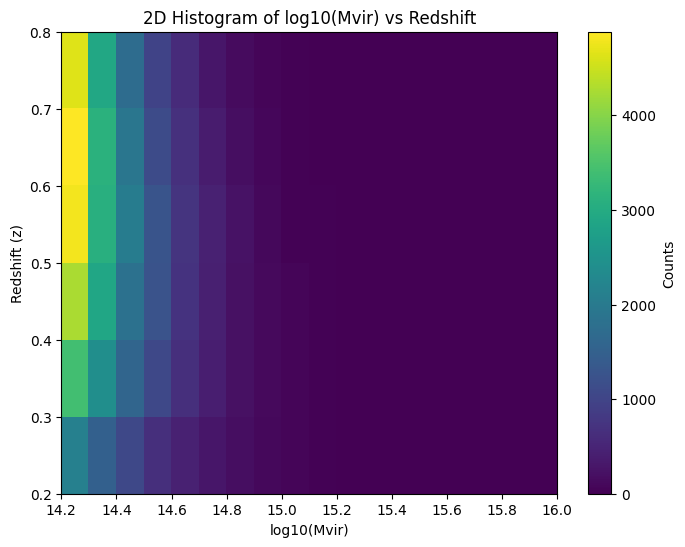

In [56]:
plt.figure(figsize=(8, 6))
plt.imshow(
    counts_mz.T,
    origin='lower',
    aspect='auto',
    extent=[bin_edges_m[0], bin_edges_m[-1], bin_edges_z[0], bin_edges_z[-1]],
    cmap='viridis'
)
plt.xlabel('log10(Mvir)')
plt.ylabel('Redshift (z)')
plt.title('2D Histogram of log10(Mvir) vs Redshift')
plt.colorbar(label='Counts')
plt.show()

In [57]:
import os
import configparser

import sys
# Add modules to path
root_path = os.path.abspath('../../')
sys.path.insert(0, root_path)
from modules.simulation import UniverseSimulator

In [91]:
def create_capish_config(mr_params, cosmo_params, area_sr):
    """Create Capish configuration."""
    config = configparser.ConfigParser()
    
    # Unified parameters
    config['parameters'] = {**cosmo_params, **mr_params}
    
    # Halo catalogue
    config['halo_catalogue'] = {
        'hmf_name': 'Despali16',
        'bias_model': 'Tinker10',
        'sky_area': str(area_sr),
        'log10m_min': '13.0',
        'log10m_max': '16.0',
        'n_mass_bins': '1000',
        'z_min': '0.1',
        'z_max': '0.8',
        'n_redshift_bins': '700',
        'mass_def_overdensity_type': 'matter',
        'mass_def_overdensity_delta': 'vir',
        'Mstar': '10',
        's': '0.0',
        'q': '1.0',
        'SSC': 'False',
        #'recompute_SSC_fiducial': 'False',
        # 'name_sigma2ij_fullsky_file': 'sigma2ij_fullsky_fiducial_zmin={}_zmax={}_nzbins={}.pkl',
        #'save_new_SSC_fiducial': 'False'
        'Omega_c_fiducial': '0.25',
        'Omega_b_fiducial': '0.049',
        'h_fiducial': '0.674',
        'sigma_8_fiducial': '0.811',
        'n_s_fiducial': '0.965'
    }
    
    # Cluster catalogue
    config['cluster_catalogue'] = {
        'add_completeness': 'False',
        'params_completeness': '1.0, 0.0, 14.0, 0.0',
        'add_photometric_redshift': 'False',
        'add_purity': 'False',
        'params_purity': '1.0, 0.0, 2.0, 0.0',
        'add_selection': 'False'
    }
    
    config['cluster_catalogue.mass_observable_relation'] = {
        'which_relation': 'Gauss'
    }
    
    config['cluster_catalogue.photometric_redshift'] = {
        'sigma_z0': '0.02'
    }
    
    # Summary statistics - updated for 4 richness bins (comma-separated without spaces)
    config['summary_statistics'] = {
        'summary_statistic': 'binned_count_mean_mass',
        'Gamma': 2/3,
        'richness_edges': ','.join(map(str, lambda_bins)),
        'redshift_edges': ','.join(map(str, z_bins)),
    }
    
    return config

In [92]:
# Mass-richness relation parameters (updated for new relation format)
MASS_RICHNESS_PARAMS = {
    'M_min': 134896288259.1656,  # 10^11.13 in solar masses
    # 'M_min': 0,  # 10^11.13 in solar masses
    'alpha_lambda': -9,
    'beta_lambda': 0.75,
    'gamma_lambda': 0.0,
    'sigma_lambda': 0.0,
    'alpha_mwl': 0.0,
    'beta_mwl': 1.0,
    'gamma_mwl': 0.0,
    'sigma_Mwl_gal': 0.,
    'sigma_Mwl_int': 0.,
    'rho': 0.
}

# Cosmological parameters
COSMO_PARAMS = {
    'Omega_m': 0.3071,
    'sigma8': 0.828,
    'Omega_b': 0.048,
    'h': 0.674,
    'ns': 0.965,
    'w0': -1,
    'wa': 0
}

# DES survey area
DES_AREA_DEG2 = 10000
DES_AREA_SR = DES_AREA_DEG2 * (np.pi/180)**2

print(f"DES survey area: {DES_AREA_DEG2} deg² ({DES_AREA_SR:.6f} sr)")

DES survey area: 10000 deg² (3.046174 sr)


In [93]:
# Define binning (now including the highest richness bin)
lambda_bins = np.array([20, 30, 45, 60, 200])
z_bins = np.array([0.2, 0.35, 0.5, 0.65])
lambda_cents = np.array([25.0, 37.5, 52.5, 130.0])

In [94]:
config = create_capish_config(MASS_RICHNESS_PARAMS, COSMO_PARAMS, DES_AREA_SR)

In [95]:
# Run simulation
simulator = UniverseSimulator(default_config=config, variable_params_names=['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda', 'gamma_lambda', 'M_min'])
fiducial_values = [COSMO_PARAMS['Omega_m'], COSMO_PARAMS['sigma8'], 
                   MASS_RICHNESS_PARAMS['alpha_lambda'], MASS_RICHNESS_PARAMS['beta_lambda'], 
                   MASS_RICHNESS_PARAMS['gamma_lambda'], MASS_RICHNESS_PARAMS['M_min']]

print("="*70)
print("SIMULATION PARAMETERS")
print("="*70)
print("\nAll Parameters (from simulator.params_values):")
for key, val in simulator.params_values.items():
    if key == 'M_min':
        print(f"  {key:16s} = {val:.3e} M☉ (log10 = {np.log10(val):.3f})")
    else:
        print(f"  {key:16s} = {val}")
print("\nSurvey Configuration:")
print(f"  Sky area         = {simulator.halo_catalogue_class.sky_area:.6f} sr ({simulator.halo_catalogue_class.sky_area * (180/np.pi)**2:.1f} deg²)")
print(f"  λ bins           = {lambda_bins}")
print(f"  z bins           = {z_bins}")
print("="*70)

summary_stats = simulator.run_simulation( fiducial_values )

SIMULATION PARAMETERS

All Parameters (from simulator.params_values):
  omega_m          = 0.3071
  sigma8           = 0.828
  omega_b          = 0.048
  h                = 0.674
  ns               = 0.965
  w0               = -1.0
  wa               = 0.0
  m_min            = 134896288259.1656
  alpha_lambda     = -9.0
  beta_lambda      = 0.75
  gamma_lambda     = 0.0
  sigma_lambda     = 0.0
  alpha_mwl        = 0.0
  beta_mwl         = 1.0
  gamma_mwl        = 0.0
  sigma_mwl_gal    = 0.0
  sigma_mwl_int    = 0.0
  rho              = 0.0

Survey Configuration:
  Sky area         = 3.046174 sr (10000.0 deg²)
  λ bins           = [ 20  30  45  60 200]
  z bins           = [0.2  0.35 0.5  0.65]


In [96]:
log10m_halo, z_true = simulator.run_simulation_halo_catalogue( fiducial_values )

In [97]:
counts_capish_mz , bin_edges_m , bin_edges_z = np.histogram2d((log10m_halo), z_true, bins=[np.arange(14.2,16,0.1), np.arange(0.2, 0.8,0.1)])
counts_mz , bin_edges_m , bin_edges_z = np.histogram2d(np.log10(Mvir_pin), z_pin, bins=[np.arange(14.2,16,0.1), np.arange(0.2,0.8,0.1)])

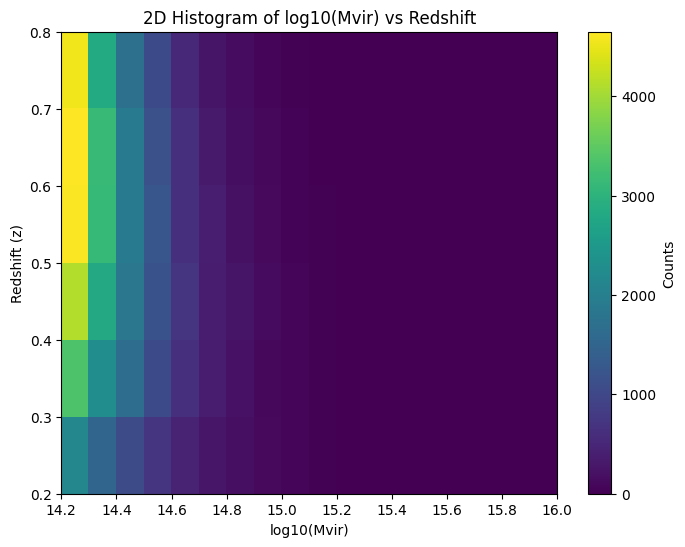

In [98]:
plt.figure(figsize=(8, 6))
plt.imshow(
    counts_capish_mz.T,
    origin='lower',
    aspect='auto',
    extent=[bin_edges_m[0], bin_edges_m[-1], bin_edges_z[0], bin_edges_z[-1]],
    cmap='viridis'
)
plt.xlabel('log10(Mvir)')
plt.ylabel('Redshift (z)')
plt.title('2D Histogram of log10(Mvir) vs Redshift')
plt.colorbar(label='Counts')
plt.show()

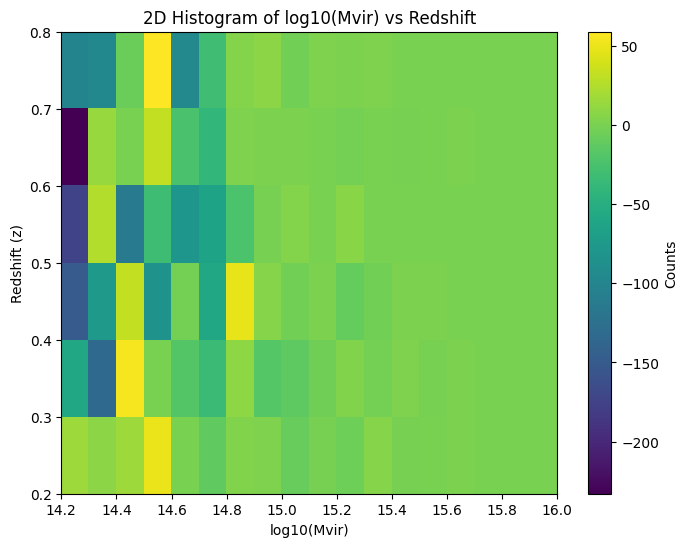

In [99]:
plt.figure(figsize=(8, 6))
plt.imshow(
    counts_capish_mz.T -counts_mz.T,
    origin='lower',
    aspect='auto',
    extent=[bin_edges_m[0], bin_edges_m[-1], bin_edges_z[0], bin_edges_z[-1]],
    cmap='viridis'
)
plt.xlabel('log10(Mvir)')
plt.ylabel('Redshift (z)')
plt.title('2D Histogram of log10(Mvir) vs Redshift')
plt.colorbar(label='Counts')
plt.show()

In [100]:
m_cents = ( bin_edges_m[1:]+ bin_edges_m[:-1] )/2.

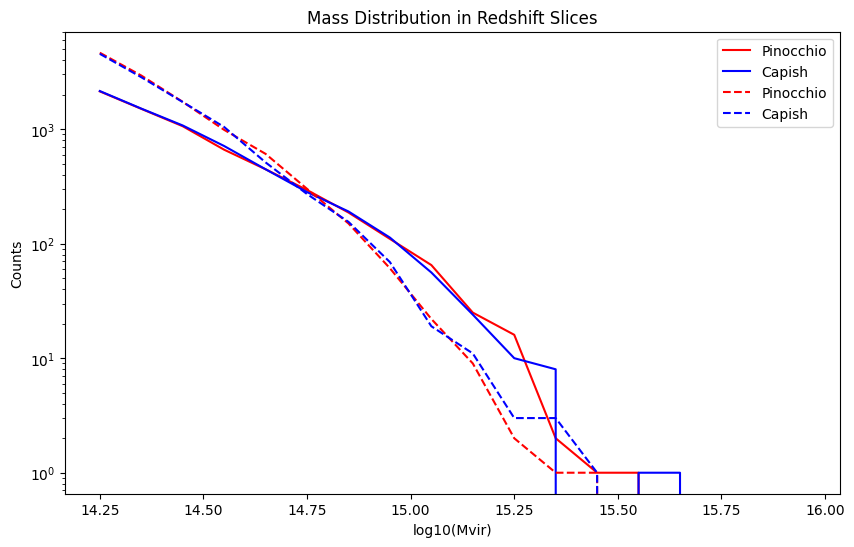

In [ ]:
# Select redshift slices to plot (e.g., z=0.2-0.3, 0.4-0.5, 0.6-0.7)
z_slices = [(0.2, 0.3), (0.4, 0.5), (0.6, 0.7)]
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))

plt.plot( m_cents , counts_mz.T[0] , 'r-', label = 'Pinocchio')
plt.plot( m_cents , counts_capish_mz.T[0] , 'b-', label = 'Capish')


plt.plot( m_cents , counts_mz.T[5] , 'r--', label = 'Pinocchio')
plt.plot( m_cents , counts_capish_mz.T[5] , 'b--' , label = 'Capish')


plt.yscale('log')
plt.xlabel('log10(Mvir)')
plt.ylabel('Counts')
plt.title('Mass Distribution in Redshift Slices')
plt.legend()
plt.show()